In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, sim2tra=True)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs, sep='')

Number of images found: 2942
Number of labels found: 2942
Number of unique characters: 1684
Characters present:{'㐌': 316, '浪': 300, '朱': 247, '\U000f047c': 214, '\U000f070b': 213, '尼': 210, '吏': 200, '𦋦': 197, '𢚸': 197, '娘': 197, '𠊛': 192, '固': 189, '拱': 172, '之': 167, '情': 161, '埃': 161, '買': 151, '芇': 146, '𠬠': 145, '衝': 143, '仙': 139, '欺': 138, '羣': 136, '𠳒': 136, '別': 135, '麻': 130, '𠓨': 127, '𧗱': 124, '爫': 122, '塘': 117, '花': 114, '𠫾': 109, '𠄩': 108, '払': 106, '渚': 106, '𡗶': 106, '浽': 104, '傷': 103, '雲': 102, '強': 102, '吶': 101, '渃': 99, '𦖑': 99, '饒': 97, '庒': 97, '如': 96, '些': 95, '分': 94, '畧': 93, '咍': 92, '鐄': 90, '時': 90, '昆': 90, '低': 90, '𢬣': 89, '𡢐': 88, '於': 88, '身': 87, '兜': 87, '𧡊': 86, '細': 84, '生': 81, '月': 79, '公': 78, '戈': 78, '皮': 78, '調': 76, '﨤': 74, '𣈜': 74, '爲': 73, '茹': 73, '沛': 73, '牢': 73, '仍': 73, '油': 73, '命': 72, '排': 70, '典': 66, '包': 66, '娥': 65, '碎': 65, '㗂': 64, '\U000f061a': 63, '𠁀': 61, '\U000f02c7': 61, '恩': 61, '迻': 59, '耒': 59, '茄': 57, '共': 57, '

## Visualize the data

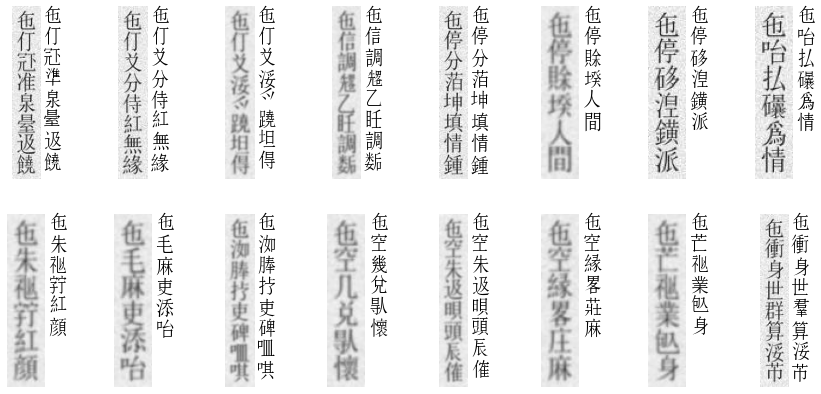

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Bidirectional, GRU,
    Lambda, RepeatVector, Permute, multiply
)
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [9]:
# https://pbcquoc.github.io/vietnamese-ocr (Vietnamese blog)
def visual_attention(feature_maps):
    _, timestep, input_dim = feature_maps.shape
    a = Permute((2, 1), name='dim_switching')(feature_maps)
    a = Dense(timestep, activation='softmax', name='attention_weights')(a)
    
    # Calculate the average of all timesteps and multiply by 100 to convert
    # the fraction obtained from the softmax calculation into a percentage
    a = Lambda(
        lambda x: tf.keras.backend.mean(x, axis=1) * 100, 
        name = 'average_weight'
    )(a)
    
    a = RepeatVector(input_dim, name='redistribute')(a)
    a = Permute((2, 1), name='attention_vector')(a) 
    return multiply([feature_maps, a], name='context_vector') 

In [10]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing output to RNN and apply attention mechanism
    x = reshape_for_cnn(x, dim_to_keep=-1)
    x = visual_attention(x)
    
    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.2,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [11]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [12]:
# imagenet_output_layer = 'block4_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

                                                                    'rnn_output[0][0]',             
                                                                    'label_length[0][0]']           
                                                                                                    
Total params: 15,162,824
Trainable params: 15,158,344
Non-trainable params: 4,480
____________________________________________________________________________________________________


# Training

In [13]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Data input pipeline

In [14]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [15]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Callbacks

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [17]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [18]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
    )

In [19]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

Start training for Fold 01:
Epoch 1/100
166/166 [==============================] - 15s 50ms/step - loss: 51.1413 - val_loss: 50.1557 - lr: 2.0000e-04
Epoch 2/100
166/166 [==============================] - 6s 34ms/step - loss: 46.2369 - val_loss: 47.5356 - lr: 2.0000e-04
Epoch 3/100
166/166 [==============================] - 5s 33ms/step - loss: 42.0686 - val_loss: 43.3435 - lr: 2.0000e-04
Epoch 4/100
166/166 [==============================] - 5s 33ms/step - loss: 32.4633 - val_loss: 28.2184 - lr: 2.0000e-04
Epoch 5/100
166/166 [==============================] - 6s 34ms/step - loss: 19.7806 - val_loss: 15.5602 - lr: 2.0000e-04
Epoch 6/100
166/166 [==============================] - 5s 33ms/step - loss: 10.9842 - val_loss: 9.7844 - lr: 2.0000e-04
Epoch 7/100
166/166 [==============================] - 6s 33ms/step - loss: 6.2243 - val_loss: 7.3606 - lr: 2.0000e-04
Epoch 8/100
166/166 [==============================] - 6s 34ms/step - loss: 3.5419 - val_loss: 5.9290 - lr: 2.0000e-04
Epoch 9/

Epoch 37: early stopping
Finish training for Fold 01

Start training for Fold 02:
Epoch 1/100
166/166 [==============================] - 12s 45ms/step - loss: 51.1403 - val_loss: 52.5567 - lr: 2.0000e-04
Epoch 2/100
166/166 [==============================] - 6s 33ms/step - loss: 46.4912 - val_loss: 48.6170 - lr: 2.0000e-04
Epoch 3/100
166/166 [==============================] - 6s 33ms/step - loss: 42.9008 - val_loss: 44.1952 - lr: 2.0000e-04
Epoch 4/100
166/166 [==============================] - 6s 34ms/step - loss: 36.5579 - val_loss: 34.6769 - lr: 2.0000e-04
Epoch 5/100
166/166 [==============================] - 6s 35ms/step - loss: 23.4877 - val_loss: 19.0072 - lr: 2.0000e-04
Epoch 6/100
166/166 [==============================] - 6s 35ms/step - loss: 12.7908 - val_loss: 13.9764 - lr: 2.0000e-04
Epoch 7/100
166/166 [==============================] - 6s 34ms/step - loss: 7.1001 - val_loss: 11.3293 - lr: 2.0000e-04
Epoch 8/100
166/166 [==============================] - 6s 34ms/step - l

Epoch 37/100
165/166 [============================>.] - ETA: 0s - loss: 0.0321
Epoch 37: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.549812
166/166 [==============================] - 6s 34ms/step - loss: 0.0322 - val_loss: 2.9215 - lr: 1.2500e-05
Epoch 38/100
165/166 [============================>.] - ETA: 0s - loss: 0.0317 - Mean edit distance: 1.543233
Restored weights from the end of epoch: 33
166/166 [==============================] - 6s 34ms/step - loss: 0.0317 - val_loss: 2.9119 - lr: 6.2500e-06
Epoch 38: early stopping
Finish training for Fold 02

Start training for Fold 03:
Epoch 1/100
166/166 [==============================] - 13s 50ms/step - loss: 51.1705 - val_loss: 50.9739 - lr: 2.0000e-04
Epoch 2/100
166/166 [==============================] - 6s 33ms/step - loss: 46.2497 - val_loss: 50.9646 - lr: 2.0000e-04
Epoch 3/100
166/166 [==============================] - 5s 33ms/step - loss: 40.0263 - val_loss: 36.1402 - lr: 2.0000e-04


165/166 [============================>.] - ETA: 0s - loss: 0.0179
Epoch 35: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.5032895
166/166 [==============================] - 6s 34ms/step - loss: 0.0179 - val_loss: 2.5112 - lr: 5.0000e-05
Epoch 36/100
165/166 [============================>.] - ETA: 0s - loss: 0.0174 - Mean edit distance: 1.4967105
Restored weights from the end of epoch: 31
166/166 [==============================] - 6s 34ms/step - loss: 0.0174 - val_loss: 2.5301 - lr: 2.5000e-05
Epoch 36: early stopping
Finish training for Fold 03

Start training for Fold 04:
Epoch 1/100
166/166 [==============================] - 12s 45ms/step - loss: 51.0173 - val_loss: 50.1961 - lr: 2.0000e-04
Epoch 2/100
166/166 [==============================] - 6s 33ms/step - loss: 46.2827 - val_loss: 50.6831 - lr: 2.0000e-04
Epoch 3/100
166/166 [==============================] - 6s 34ms/step - loss: 41.6305 - val_loss: 41.1877 - lr: 2.0000e-04
Epoch 4/10

Epoch 35/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0206 - val_loss: 2.7373 - lr: 2.5000e-05
Epoch 36/100
165/166 [============================>.] - ETA: 0s - loss: 0.0203
Epoch 36: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
 - Mean edit distance: 1.4506578
166/166 [==============================] - 5s 33ms/step - loss: 0.0203 - val_loss: 2.7615 - lr: 2.5000e-05
Epoch 37/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0199 - val_loss: 2.7338 - lr: 1.2500e-05
Epoch 38/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0197 - val_loss: 2.7474 - lr: 1.2500e-05
Epoch 39/100
165/166 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 39: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.4539474
166/166 [==============================] - 6s 34ms/step - loss: 0.0195 - val_loss: 2.7466 - lr: 1.2500e-05
Epoch 40/100
166/166 [===========================

Epoch 29/100
165/166 [============================>.] - ETA: 0s - loss: 0.0248
Epoch 29: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.6282895
166/166 [==============================] - 5s 33ms/step - loss: 0.0248 - val_loss: 2.7899 - lr: 2.0000e-04
Epoch 30/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0228 - val_loss: 2.7369 - lr: 1.0000e-04
Epoch 31/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0217 - val_loss: 2.7166 - lr: 1.0000e-04
Epoch 32/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0205 - val_loss: 2.7720 - lr: 1.0000e-04
Epoch 33/100
165/166 [============================>.] - ETA: 0s - loss: 0.0196
Epoch 33: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.5767545
166/166 [==============================] - 5s 33ms/step - loss: 0.0196 - val_loss: 2.7528 - lr: 1.0000e-04
Epoch 34/100
166/166 [==========================

Epoch 29/100
166/166 [==============================] - 6s 38ms/step - loss: 0.0253 - val_loss: 2.6393 - lr: 2.0000e-04
Epoch 30/100
165/166 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 30: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.5394737
166/166 [==============================] - 6s 37ms/step - loss: 0.0231 - val_loss: 2.6665 - lr: 2.0000e-04
Epoch 31/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0213 - val_loss: 2.6490 - lr: 1.0000e-04
Epoch 32/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0201 - val_loss: 2.6117 - lr: 1.0000e-04
Epoch 33/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0192 - val_loss: 2.6442 - lr: 1.0000e-04
Epoch 34/100
165/166 [============================>.] - ETA: 0s - loss: 0.0183
Epoch 34: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.5657895
166/166 [==========================

Epoch 28/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0307 - val_loss: 2.5683 - lr: 2.0000e-04
Epoch 29/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0278 - val_loss: 2.5228 - lr: 2.0000e-04
Epoch 30/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0254 - val_loss: 2.5350 - lr: 2.0000e-04
Epoch 31/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0231 - val_loss: 2.4876 - lr: 2.0000e-04
Epoch 32/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0211 - val_loss: 2.4689 - lr: 2.0000e-04
Epoch 33/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0193 - val_loss: 2.4824 - lr: 2.0000e-04
Epoch 34/100
166/166 [==============================] - ETA: 0s - loss: 0.0178
Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.5372807
166/166 [==============================] - 6s 35ms/step - loss: 0.0178 - val_loss: 2.4870 -

Epoch 16/100
166/166 [==============================] - 6s 35ms/step - loss: 0.1264 - val_loss: 2.7865 - lr: 2.0000e-04
Epoch 17/100
166/166 [==============================] - 6s 34ms/step - loss: 0.1070 - val_loss: 2.7558 - lr: 2.0000e-04
Epoch 18/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0898 - val_loss: 2.6926 - lr: 2.0000e-04
Epoch 19/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0769 - val_loss: 2.6985 - lr: 2.0000e-04
Epoch 20/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0663 - val_loss: 2.6721 - lr: 2.0000e-04
Epoch 21/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0592 - val_loss: 2.6260 - lr: 2.0000e-04
Epoch 22/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0535 - val_loss: 2.6567 - lr: 2.0000e-04
Epoch 23/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0519 - val_loss: 2.5877 - lr: 2.0000e-04
Epoch 24/100
166/166 [==================

Epoch 3/100
166/166 [==============================] - 6s 35ms/step - loss: 43.0494 - val_loss: 45.4923 - lr: 2.0000e-04
Epoch 4/100
166/166 [==============================] - 6s 36ms/step - loss: 36.1933 - val_loss: 33.0949 - lr: 2.0000e-04
Epoch 5/100
166/166 [==============================] - 6s 35ms/step - loss: 24.6324 - val_loss: 23.3084 - lr: 2.0000e-04
Epoch 6/100
166/166 [==============================] - 6s 35ms/step - loss: 15.2092 - val_loss: 15.3052 - lr: 2.0000e-04
Epoch 7/100
166/166 [==============================] - 6s 35ms/step - loss: 8.7121 - val_loss: 11.3255 - lr: 2.0000e-04
Epoch 8/100
166/166 [==============================] - 6s 35ms/step - loss: 5.0901 - val_loss: 8.9449 - lr: 2.0000e-04
Epoch 9/100
166/166 [==============================] - 6s 35ms/step - loss: 3.0260 - val_loss: 7.9844 - lr: 2.0000e-04
Epoch 10/100
166/166 [==============================] - 6s 35ms/step - loss: 1.8502 - val_loss: 7.5846 - lr: 2.0000e-04
Epoch 11/100
166/166 [================

Epoch 40/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0154 - val_loss: 3.1698 - lr: 5.0000e-05
Epoch 41/100
165/166 [============================>.] - ETA: 0s - loss: 0.0149
Epoch 41: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.6589912
166/166 [==============================] - 6s 35ms/step - loss: 0.0149 - val_loss: 3.1622 - lr: 5.0000e-05
Epoch 42/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0149 - val_loss: 3.1474 - lr: 2.5000e-05
Epoch 43/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0145 - val_loss: 3.1299 - lr: 2.5000e-05
Epoch 44/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0141 - val_loss: 3.1552 - lr: 2.5000e-05
Epoch 45/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0139 - val_loss: 3.1203 - lr: 2.5000e-05
Epoch 46/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0136 - val_loss: 3.1266 -

166/166 [==============================] - 6s 35ms/step - loss: 0.0641 - val_loss: 3.8405 - lr: 5.0000e-05
Epoch 24/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0610 - val_loss: 3.7896 - lr: 5.0000e-05
Epoch 25/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0581 - val_loss: 3.8143 - lr: 5.0000e-05
Epoch 26/100
165/166 [============================>.] - ETA: 0s - loss: 0.0558
Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.8223684
166/166 [==============================] - 6s 35ms/step - loss: 0.0558 - val_loss: 3.8140 - lr: 5.0000e-05
Epoch 27/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0542 - val_loss: 3.6834 - lr: 2.5000e-05
Epoch 28/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0528 - val_loss: 3.6747 - lr: 2.5000e-05
Epoch 29/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0511 - val_loss: 3.6915 - lr: 2.5000e-

## Get the best CRNN model and its results

In [20]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 1.477913498878479
19/19 [==============================] - 0s 15ms/step - loss: 2.1164
Fold 02 - Mean edit distance: 1.5399435758590698
19/19 [==============================] - 0s 14ms/step - loss: 2.9085
Fold 03 - Mean edit distance: 1.4627193212509155
19/19 [==============================] - 0s 14ms/step - loss: 2.4816
Fold 04 - Mean edit distance: 1.4473683834075928
19/19 [==============================] - 0s 14ms/step - loss: 2.7338
Fold 05 - Mean edit distance: 1.5866228342056274
19/19 [==============================] - 0s 15ms/step - loss: 2.7166
Fold 06 - Mean edit distance: 1.5361841917037964
19/19 [==============================] - 0s 14ms/step - loss: 2.6117
Fold 07 - Mean edit distance: 1.512061357498169
19/19 [==============================] - 0s 14ms/step - loss: 2.4033
Fold 08 - Mean edit distance: 1.4835525751113892
19/19 [==============================] - 0s 14ms/step - loss: 2.4708
Fold 09 - Mean edit distance: 1.637061357498169
19/19 [===

Fold 0 has the best loss: 2.1163902282714844


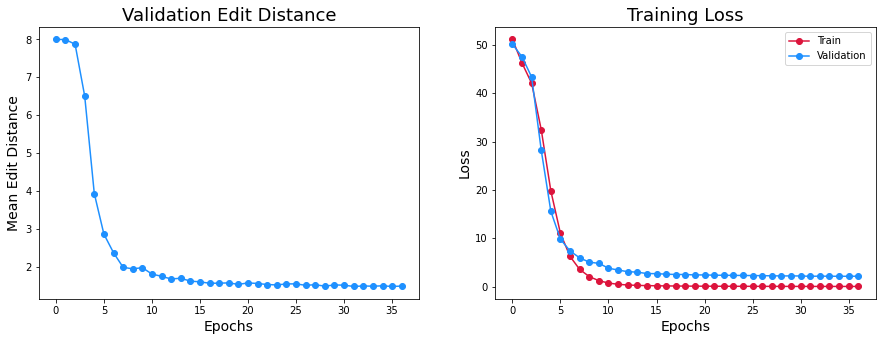

In [21]:
print('Fold', best_fold_idx, 'has the best loss:', best_loss)
plot_training_results(best_history, best_edist_log, 'CRNNxNonPreHS.png')
best_model.save('CRNNxNonPreHS.h5')

# Inference

In [22]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

## Reload the model

In [23]:
reloaded_model = load_model('CRNNxNonPreHS.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_1"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

                                                                    'label_length[0][0]',           
                                                                    'rnn_output[0][0]']             
                                                                                                    
Total params: 15,162,824
Trainable params: 15,158,344
Non-trainable params: 4,480
____________________________________________________________________________________________________


## On test dataset

Batch 1: ['㐌仃𠬠浽爫蹺坦𠊚', '㐌咍払𥘀爲情', '㐌洳䏾𢪀吏碑𠰘唭', '㐱𠲖圭舘\U000f070b命', '㝵戈𣎃論㐌苔𠀧𢆥', '㝵𠸗縸案苔𠫾', '㝵𫢩聖主治𠁀', '㤕娘羣拙雙親', '䏾核𦝄㐌拮頭', '䜹浪停𥙩爫制', '䜹浪\U000f0152﨤知音', '䝨之柴𠰺科塲羣賖', '丿𦖑𠳒吶𣈗\U000f0268吏傷', '丿\U000f0993仙直𠬠徐調衝', '些低沛摱埃兜𦓡浪', '仍\U000f047c㙮𢖵𢷮愁']

Batch 2: ['仍\U000f047c煩悶𣎀𣈜', '仙浪各注迻些', '仙浪感\U000f0482月娥', '仰𬂙量𢌌皮𨕭', '侈𦖑𣈙㐌典期', '係\U000f047c異相乙\U000f047c才高', '俸兜吏﨤\U000f070b𠊛', '倍之柳押花奈', '停料𠴍\U000f070b𠄩𠳒', '傕匕㛪唉金連', '催催些㐌默𢬣埃耒', '傷臺拱\U000f070b身𠊛', '像尼本寔𫯳娘𡎢低', '儉䀡氏思吝懇𠳨連', '共払結𩯀車絲仍𣈜', '共饒𢴿𢩮調連阻𦋦']

Batch 3: ['衝𡽫苦料𡨌棱苦筭', '幾吱不\U000f0482𠊛唭\U000f07c1良', '分𫳵分薄如𪿙', '別包功摱𧵑稅', '別包饒浽風塵', '制朱柳\U000f01cf花吱', '刼紅顔固蒙萌', '前恩思報念徘徊', '勸昆辰渚多芒', '吀柴𡮇㐌仕𢭂𠬠𢈱', '各官埃乃𧡊麻調傷', '同䦕\U000f02c7淡𠫾𠓨細尼', '吝吝𣈜𩙌𣈘𦝄', '吶𦋦𣅶畧根源仍\U000f047c', '咍\U000f0993𬋩格羣𥱬像尼', '咹爫牢吶爫牢碑𣇞']



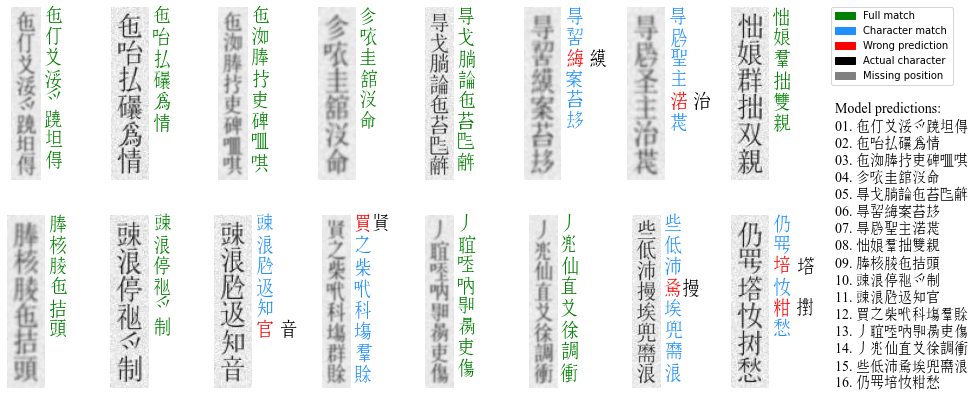

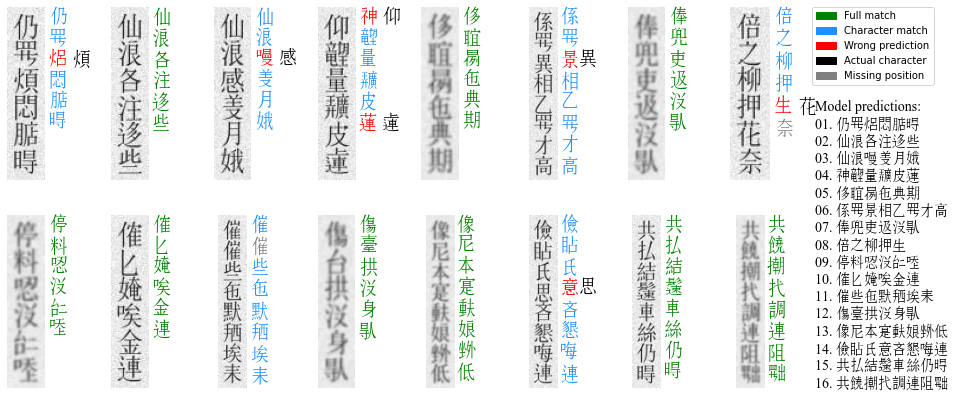

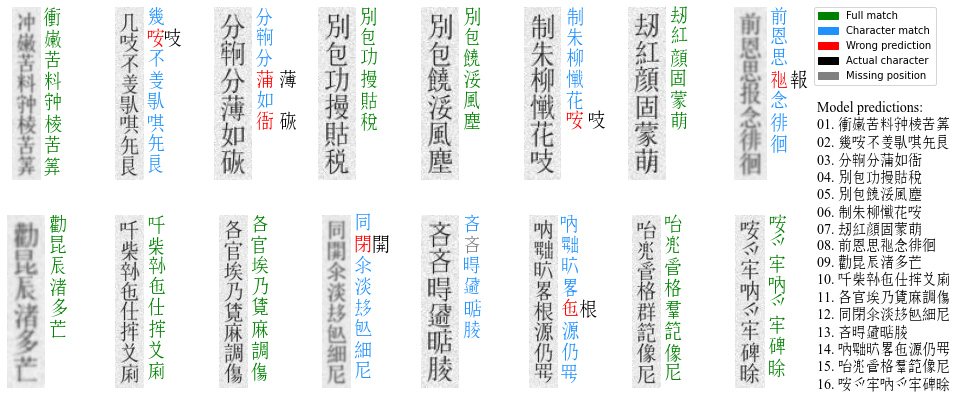

In [61]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [62]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史記全書


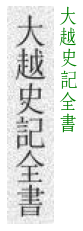

In [63]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))